# Bike Lane Analysis

In this document we perform basic exploratory data analysis to give suggestions of where Denver should build new bike lanes. We perform a few different techniques to paint an overall picture of the scenario.

## Who Can Safely Bike to CU Denver

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import csv

In [43]:
def node_plotting(url,string):
    #import nodes and edges for plotting purposes
    edge_info = pd.read_csv('plot_edge_data.csv', names = ['tail','head','existing_f','fullname','fromname','toname','start','end','line','path_codes','dist','geometry'],header = 0)
    node_info = pd.read_csv('plot_node_data.csv', names = ['long', 'lat', 'node'], header = 0)
    
    data_CU = np.genfromtxt(url, delimiter=",")
    distance_CU = data_CU[:,-1]
    #nodes that can reach destination safely
    feasible_nodes_CU = np.where(distance_CU < np.Inf)[0]
    # nodes that cannot get to destination safely
    infeasible_nodes_CU = np.where(distance_CU == np.Inf)[0]
    
    #get coordinates of feasible nodes
    feasible_node_coords = node_info[node_info['node'].isin(feasible_nodes_CU)]
    feasible_node_gdf = gpd.points_from_xy(feasible_node_coords.long, feasible_node_coords.lat, crs="EPSG:4326")

    #get coordnates of infeasible nodes
    infeasible_node_coords = node_info[node_info['node'].isin(infeasible_nodes_CU)]
    infeasible_node_gdf = gpd.points_from_xy(infeasible_node_coords.long, infeasible_node_coords.lat, crs="EPSG:4326")

    #convert edge_data to geopandas dataframe for plotting
    #for some reason you need to comment out this line if you are running the plot for the same dataset twice in a row
    edge_info['geometry'] = edge_info['geometry'].apply(wkt.loads)
    edge_gdf = gpd.GeoDataFrame(edge_info, geometry = edge_info['geometry'])
    
    #plot all things on same figure and save it
    f, ax = plt.subplots(1, 1, figsize=(20, 20), sharex=True, sharey=True)
    edge_gdf.plot(linewidth = 4,color='black', ax=ax, zorder=-1, aspect = 1)
    (gpd.GeoDataFrame(feasible_node_gdf, geometry=feasible_node_gdf)).plot(markersize = 50,color = 'green', ax = ax, aspect = 1)
    (gpd.GeoDataFrame(infeasible_node_gdf, geometry=infeasible_node_gdf)).plot(markersize = 50,color = 'red', ax = ax, aspect = 1)
    ax.axis("off")
    plt.title('%s Cautious Cyclist' %string, fontsize = 30)
#     plt.savefig(string+'.png')
    plt.show()

### Auraria Campus

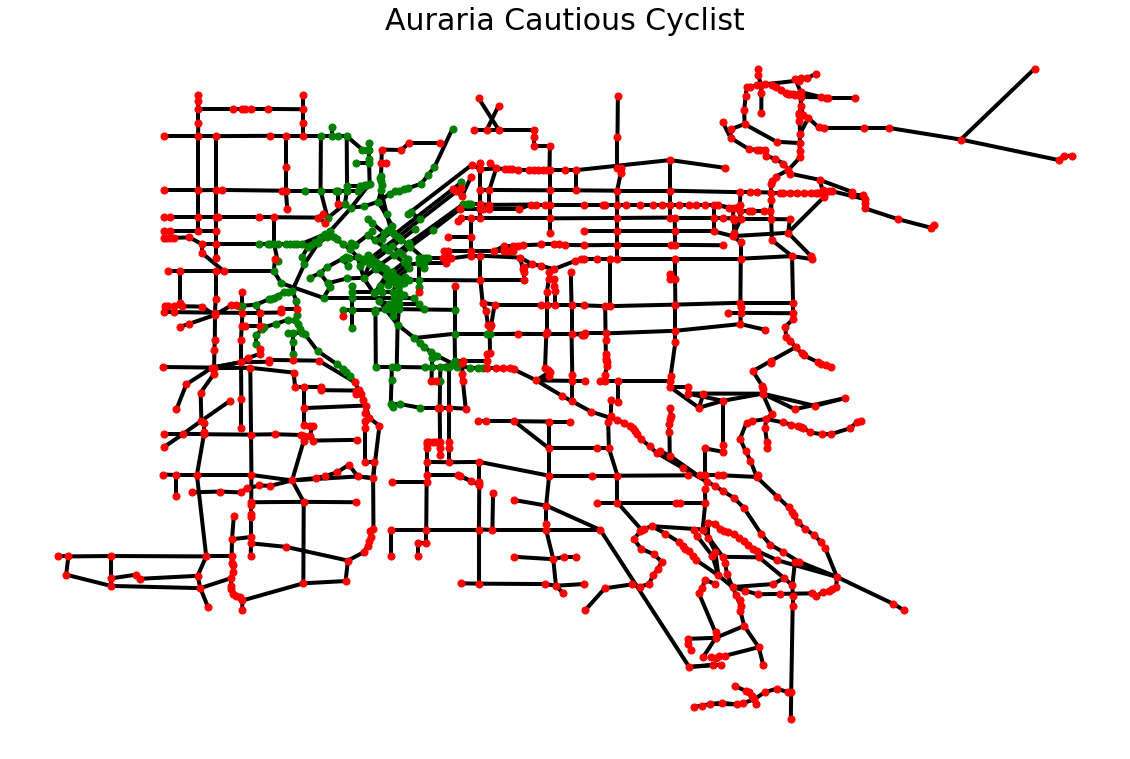

In [44]:
#cautious distances
url_CU = "https://raw.githubusercontent.com/DillWithIt77/D2P_Spring_2022/main/tau_results/auraria_tau_distances_cautious.csv"
#adventurous distances
# url_CU = "https://raw.githubusercontent.com/DillWithIt77/D2P_Spring_2022/main/tau_results/auraria_tau_distances_risky.csv"
string = 'Auraria'
node_plotting(url_CU, string)

### University of Denver

In [ ]:
#cautious distances
url_CU = "https://raw.githubusercontent.com/DillWithIt77/D2P_Spring_2022/main/tau_results/DU_tau_distances_cautious.csv"
#adventurous distances
# url_CU = "https://raw.githubusercontent.com/DillWithIt77/D2P_Spring_2022/main/tau_results/DU_tau_distances_risky.csv"
string = 'University of Denver'
node_plotting(url_CU, string)

### City Park

In [ ]:
#cautious distances
url_CU = "https://raw.githubusercontent.com/DillWithIt77/D2P_Spring_2022/main/tau_results/citypark_tau_distances_cautious.csv"
#adventurous distances
# url_CU = "https://raw.githubusercontent.com/DillWithIt77/D2P_Spring_2022/main/tau_results/citypark_tau_distances_risky.csv"
string = 'City Park'
node_plotting(url_CU, string)

### 5 Points

In [ ]:
#cautious distances
url_CU = "https://raw.githubusercontent.com/DillWithIt77/D2P_Spring_2022/main/tau_results/5points_tau_distances_cautious.csv"
#adventurous distances
# url_CU = "https://raw.githubusercontent.com/DillWithIt77/D2P_Spring_2022/main/tau_results/5points_tau_distances_risky.csv"
string = '5 Points'
node_plotting(url_CU, string)

### Union Station

In [ ]:
#cautious distances
url_CU = "https://raw.githubusercontent.com/DillWithIt77/D2P_Spring_2022/main/tau_results/union_tau_distances_cautious.csv"
#adventurous distances
# url_CU = "https://raw.githubusercontent.com/DillWithIt77/D2P_Spring_2022/main/tau_results/union_tau_distances_risky.csv"
string = 'Union Station'
node_plotting(url_CU, string)

## Which Routes Should Be Shortened

In this block, we analyze nodes that are much further from CU Denver by biking safely than by throwing caution to the wind and riding wherever we want.

In [5]:
def dist_diffs(url_sp, url_tau):
    data_CU_shortest = np.genfromtxt(url_sp, delimiter=",")[1:,1]
    data_CU_tau = np.genfromtxt(url_tau, delimiter=",")
    distance_CU_tau = data_CU_tau[:,-1]
    #nodes that can reach destination safely
    feasible_nodes_CU = np.where(distance_CU_tau < np.Inf)[0]
    # nodes that cannot get to destination safely
    infeasible_nodes_CU = np.where(distance_CU_tau == np.Inf)[0]

    #distance of shortest paths feasible with tau
    shortdist_CU_feas = data_CU_shortest[feasible_nodes_CU]
    #distance of shortest paths that are feasible with cautious tau
    taudist_CU_feas = distance_CU_tau[feasible_nodes_CU]
    
    dist_inc = taudist_CU_feas - shortdist_CU_feas
    big_inc = np.argsort(dist_inc)[::-1]
    increased_nodes = feasible_nodes_CU[big_inc]
    
    return increased_nodes

In [6]:
def row_conversion(csvreader):
    rows = []
    for row in csvreader:
        arr = np.array(row,dtype = float)
        rows.append(list(arr))
    return rows

In [7]:
def top_paths(csvreader,dest,top_num,increased_nodes):
    top_paths = []
    for i in csvreader:
        if len(i) > 0:
            if (i[0] in increased_nodes[:top_num]) & (i[len(i)-1] == dest):
                top_paths.append(i)
    return top_paths

In [8]:
def path_edges(paths):
    path_edges = []
    for j in paths:
#         shortest_path = np.zeros((len(j)-1,2))
        for i in range(len(j)-1):
            path_edges.append([j[i],j[i+1]])
    return path_edges

In [9]:
def path_plot(edge_data, values_tau, counts_tau):
    edges = []
    types = []
    for i in range(len(values_tau)):
        if(edge_data[(edge_data['tail'] == values_tau[i,0]) & (edge_data['head']==values_tau[i,1])].line.empty):
            edges.append(edge_data[(edge_data['head'] == values_tau[i,0]) & (edge_data['tail']==values_tau[i,1])].line)
            types.append(edge_data[(edge_data['head'] == values_tau[i,0]) & (edge_data['tail']==values_tau[i,1])].existing_f)
        else:
            edges.append(edge_data[(edge_data['tail'] == values_tau[i,0]) & (edge_data['head']==values_tau[i,1])].line)
            types.append(edge_data[(edge_data['tail'] == values_tau[i,0]) & (edge_data['head']==values_tau[i,1])].existing_f)

    edges_df = pd.DataFrame(data = np.array(edges), columns = ['lines'])
    edges_df['counts'] = counts_tau
    edges_df['path_codes'] = np.array(types)
    conditions_1 = [(edges_df['path_codes']=='Bike Lane'),
                  (edges_df['path_codes']=='Buffered Bike Lane'),
                  (edges_df['path_codes']=='Neighborhood Bikeway'),
                  (edges_df['path_codes']=='Protected Bike Lane'),
                  (edges_df['path_codes']=='Shared Roadway'),
                  (edges_df['path_codes']=='Shared Use Path'),
                  (edges_df['path_codes']=='Trail')]
    colors = ['#FE6100','#DC267F','#785EF0','#DC267F','#FFB000','#648FFF','#648FFF'] #orange, pink, purple, yellow, blue
    edges_df['color'] = np.select(conditions_1, colors)
    conditions_2 = [(edges_df['counts']<=10),
                  ((edges_df['counts']>10) & (edges_df['counts']<=20)),
                  ((edges_df['counts']>20) & (edges_df['counts']<=30)),
                  ((edges_df['counts']>30) & (edges_df['counts']<=40)),
                   ((edges_df['counts']>40) & (edges_df['counts']<=70))]
    vals = ['#0037C7','#5A82F3','#1EBED6','#FF5757','#FF0000'] #dark blue to dark red
    edges_df['freq'] = np.select(conditions_2, vals)
    edges_df['geometry'] = edges_df['lines'].apply(wkt.loads)
    edges_geo_df = gpd.GeoDataFrame(edges_df, geometry=edges_df['geometry'])
    return edges_geo_df

In [26]:
def tau_vs_sp(sp_csvreader, tau_csvreader, dest, top_num,url_sp, url_tau, string, string2):
    #read in edge information
    edge_info = pd.read_csv('plot_edge_data.csv', names = ['tail','head','existing_f','fullname','fromname','toname','start','end','line','path_codes','dist','geometry'],header = 0)
    edge_info['geometry'] = edge_info['geometry'].apply(wkt.loads)
    edge_gdf = gpd.GeoDataFrame(edge_info, geometry = edge_info['geometry'])
    
    #read csv files and make them lists
    sp_csv = row_conversion(sp_csvreader)
    tau_csv = row_conversion(tau_csvreader)
    
    #find all paths that have differences
    increased_nodes = dist_diffs(url_sp, url_tau)
    
    #find the top number of paths for tau and regular shortest path
    top_paths_sp = top_paths(sp_csv,dest,top_num,increased_nodes)
    top_paths_tau = top_paths(tau_csv,dest,top_num,increased_nodes)
    
    #get paths
    sp_path_edges = path_edges(top_paths_sp)
    tau_path_edges = path_edges(top_paths_tau)
    
    #get unique paths
    values, counts = np.unique(np.array(sp_path_edges), return_counts=True, axis = 0)
    values_tau, counts_tau = np.unique(np.array(tau_path_edges), return_counts=True, axis = 0)
    
    #get geo_dataframes for plotting paths
    sp_edges_geo_df = path_plot(edge_gdf, values, counts)
    tau_edges_geo_df = path_plot(edge_gdf, values_tau, counts_tau)
    
    #plot paths (tau is blue and shortest path is red)
    f, ax = plt.subplots(1, 1, figsize=(30, 30), sharex=True, sharey=True)
    all_edges = edge_gdf.plot(linewidth = 7,color='black', ax=ax, zorder=-1)
    sp_edges_geo_df.plot(color = 'red', ax = ax, linewidth = 7, zorder = 1,legend = True)
    tau_edges_geo_df.plot(color = 'blue', ax = ax, linewidth = 4, zorder = 2,legend = True)
    ax.axis("off")
    plt.title('%s Tau vs Regular Shortest Path for %s' %(string,string2), fontsize = 30)
#     plt.savefig('sp_path_types.png')
    plt.show()

### Auraria Campus

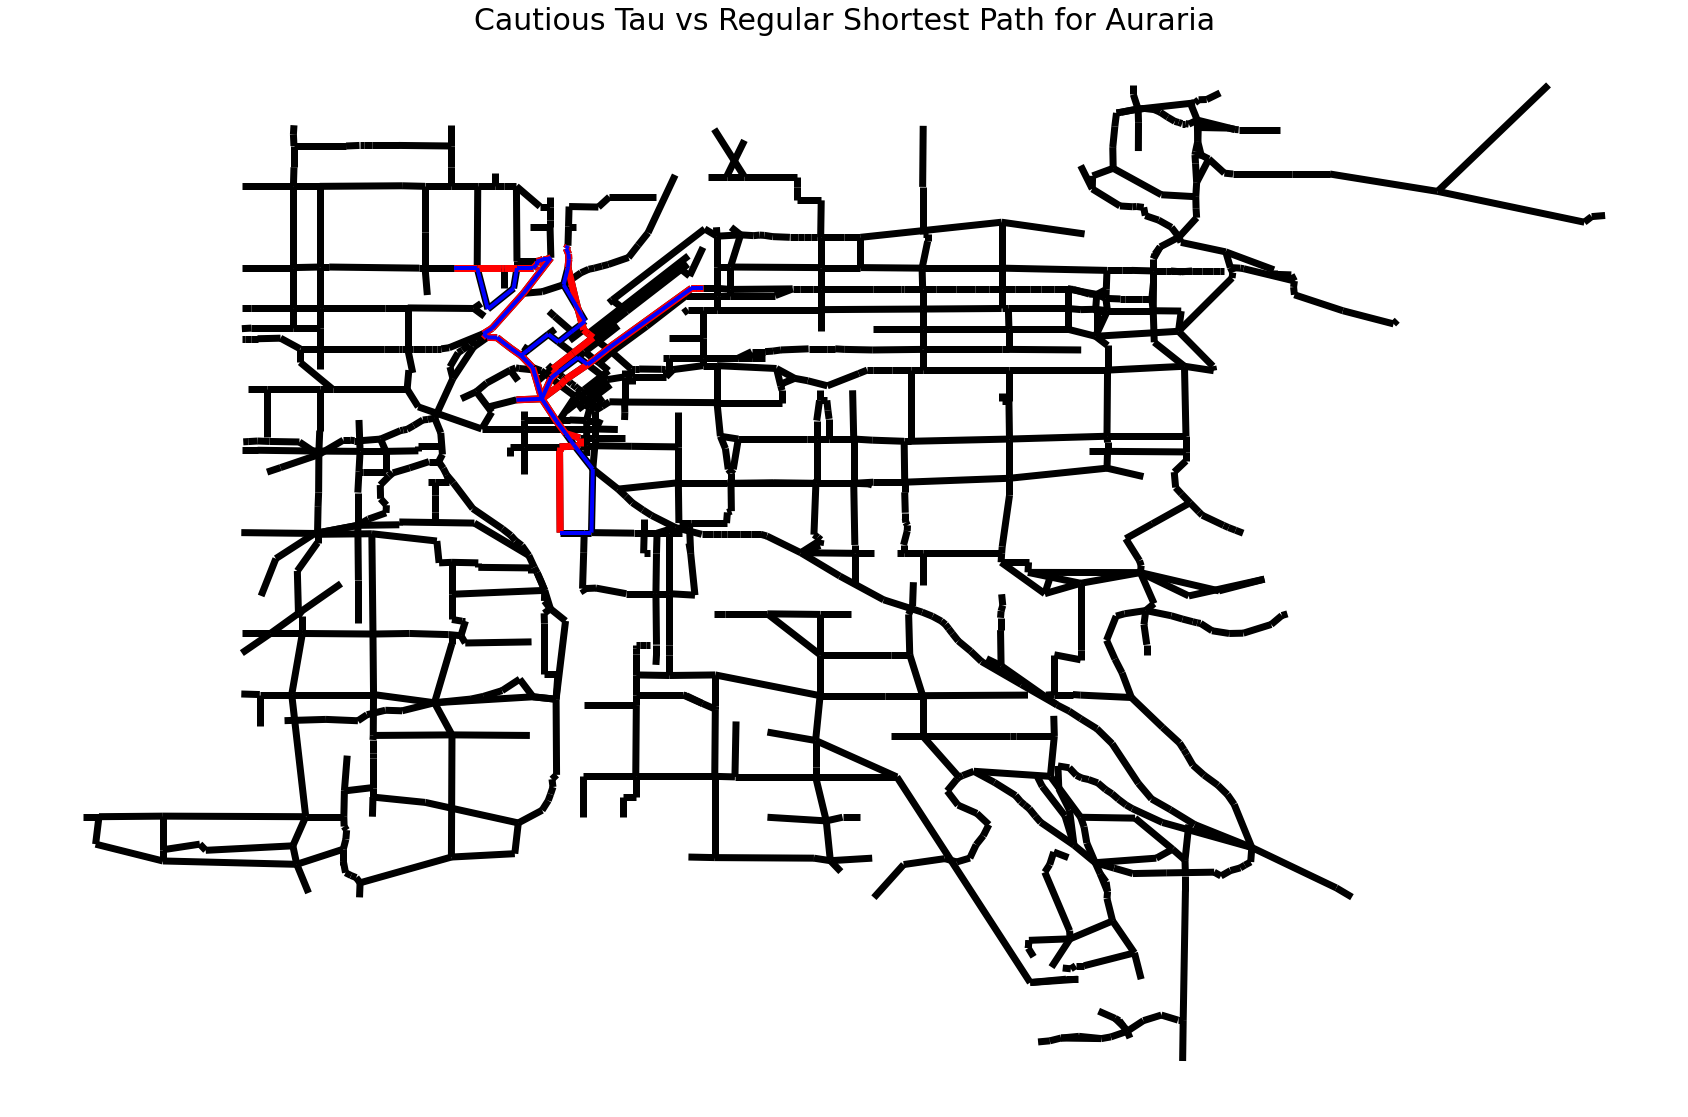

In [32]:
auraria_sp = csv.reader(open('auraria_sp.csv'), delimiter=',')
dest = 26
top_num = 5
url_sp = "https://raw.githubusercontent.com/DillWithIt77/D2P_Spring_2022/main/shortest_path_res/auraria_res.csv"
string2 = "Auraria"

# Cautious cyclist
auraria_tau_c = csv.reader(open('tau_results/auraria_tau_cautious_paths.csv'), delimiter=',')
url_tau_c = "https://raw.githubusercontent.com/DillWithIt77/D2P_Spring_2022/main/tau_results/auraria_tau_distances_cautious.csv"
string = "Cautious"

tau_vs_sp(auraria_sp, auraria_tau_c, dest, top_num, url_sp, url_tau_c, string, string2)

# #Adventurous cyclist
# auraria_tau_r = csv.reader(open('tau_results/auraria_tau_risky_paths.csv'), delimiter=',')
# url_tau_r = "https://raw.githubusercontent.com/DillWithIt77/D2P_Spring_2022/main/tau_results/auraria_tau_distances_risky.csv"
# string = "Risky"
# tau_vs_sp(auraria_sp, auraria_tau_r, dest, top_num, url_sp, url_tau_r, string, string2)


### University of Denver

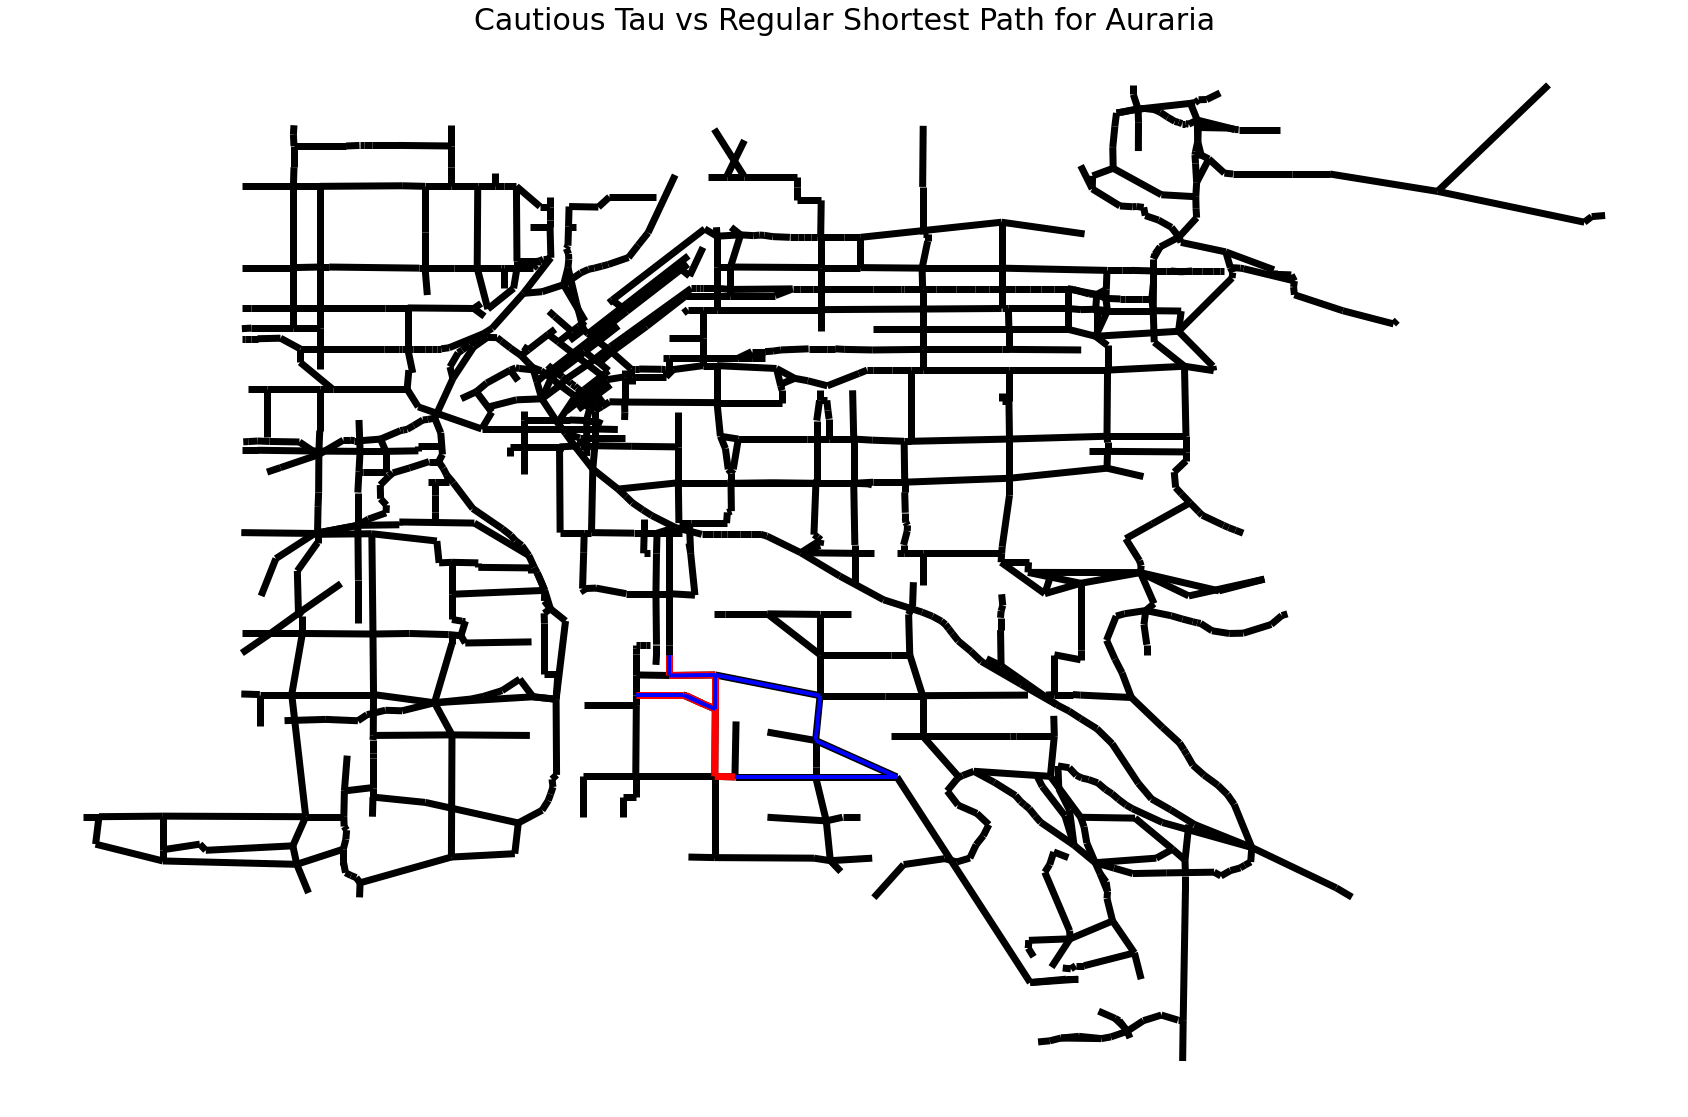

In [35]:
#plot tau and shortest path for starting 5 nodes from above to auraria
du_sp = csv.reader(open('du_sp.csv'), delimiter=',')
dest = 427
top_num = 5
url_sp = "https://raw.githubusercontent.com/DillWithIt77/D2P_Spring_2022/main/shortest_path_res/DU_res.csv"
string2 = "University of Denver"

# Cautious cyclist
du_tau_c = csv.reader(open('tau_results/DU_tau_cautious_paths.csv'), delimiter=',')
url_tau_c = "https://raw.githubusercontent.com/DillWithIt77/D2P_Spring_2022/main/tau_results/DU_tau_distances_cautious.csv"
string = "Cautious"

tau_vs_sp(du_sp, du_tau_c, dest, top_num, url_sp, url_tau_c, string, string2)

# #Adventurous cyclist
# du_tau_r = csv.reader(open('tau_results/DU_tau_risky_paths.csv'), delimiter=',')
# url_tau_r = "https://raw.githubusercontent.com/DillWithIt77/D2P_Spring_2022/main/tau_results/DU_tau_distances_risky.csv"
# string = "Risky"
# tau_vs_sp(du_sp, du_tau_r, dest, top_num, url_sp, url_tau_r, string, string2)

### 5 Points

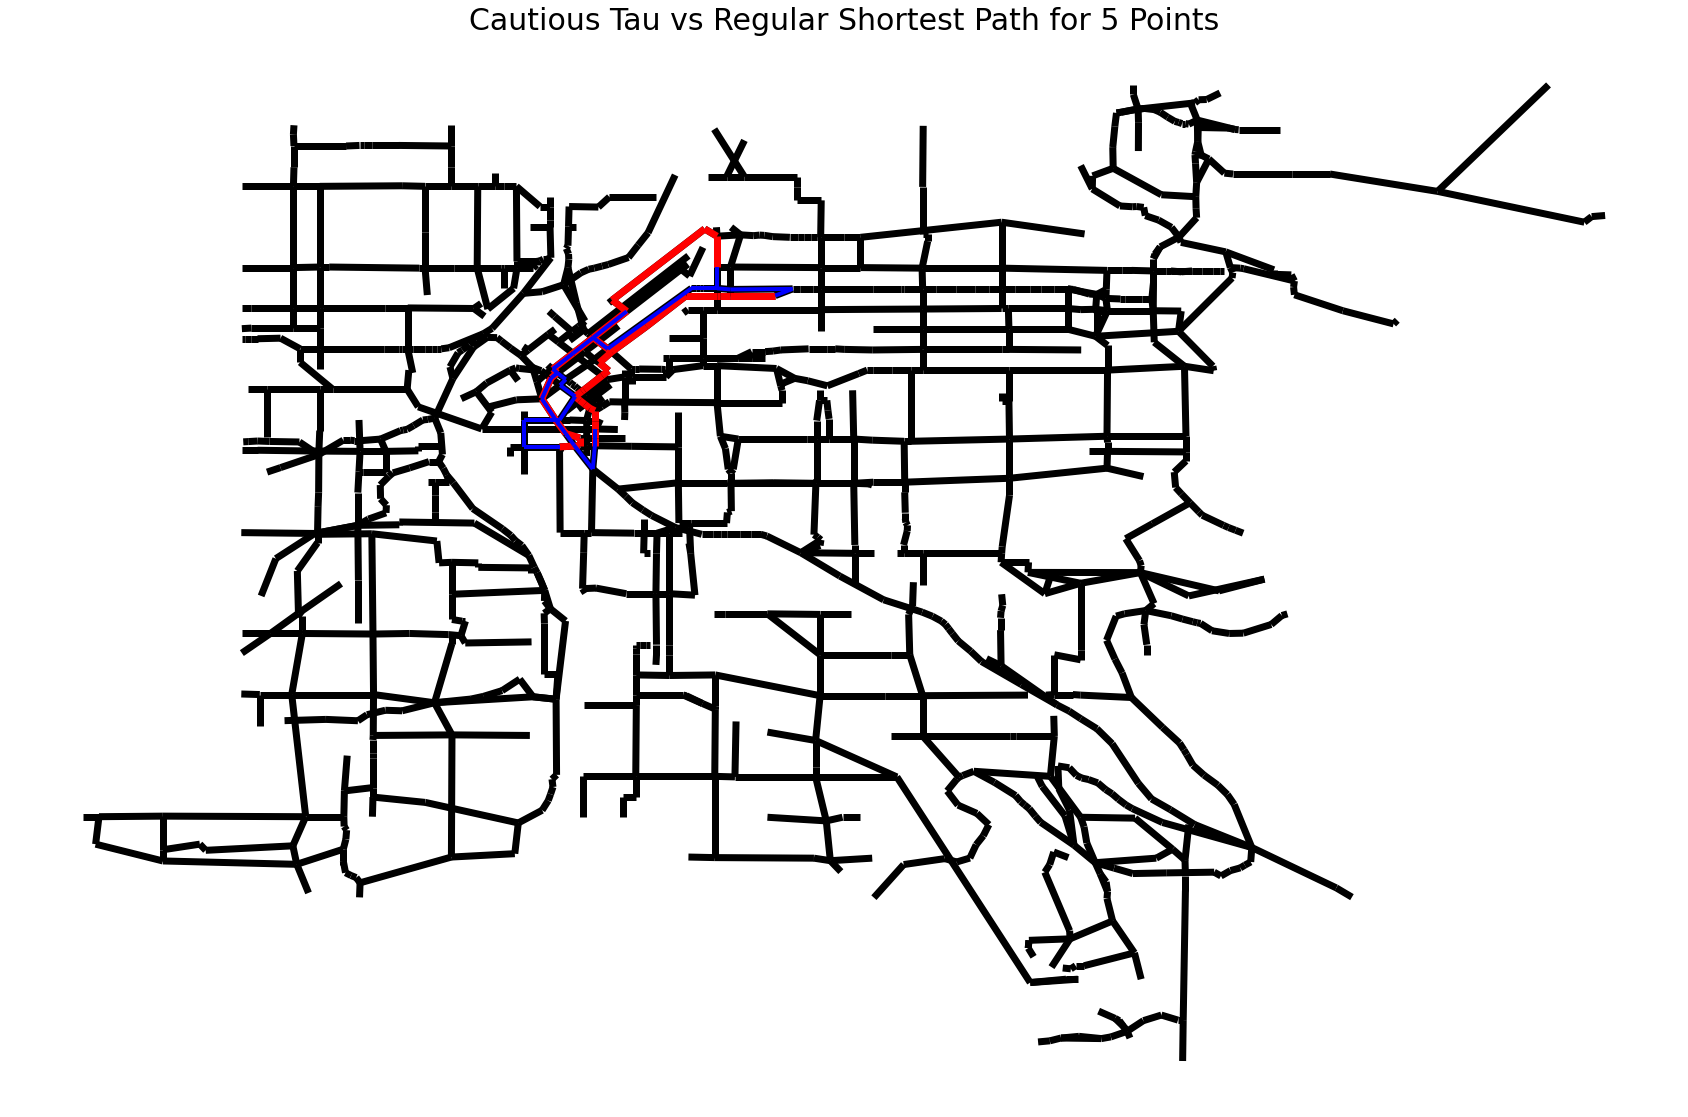

In [37]:
dcm_sp = csv.reader(open('dcm_sp.csv'), delimiter=',')
dest = 112
top_num = 5
url_sp = "https://raw.githubusercontent.com/DillWithIt77/D2P_Spring_2022/main/shortest_path_res/DCM_res.csv"
string2 = "5 Points"

# Cautious cyclist
dcm_tau_c = csv.reader(open('tau_results/5points_tau_cautious_paths.csv'), delimiter=',')
url_tau_c = "https://raw.githubusercontent.com/DillWithIt77/D2P_Spring_2022/main/tau_results/5points_tau_distances_cautious.csv"
string = "Cautious"

tau_vs_sp(dcm_sp, dcm_tau_c, dest, top_num, url_sp, url_tau_c, string, string2)

# #Adventurous cyclist
# dcm_tau_r = csv.reader(open('tau_results/5points_tau_risky_paths.csv'), delimiter=',')
# url_tau_r = "https://raw.githubusercontent.com/DillWithIt77/D2P_Spring_2022/main/tau_results/5points_tau_distances_risky.csv"
# string = "Risky"
# tau_vs_sp(dcm_sp, dcm_tau_r, dest, top_num, url_sp, url_tau_r, string, string2)

### City Park

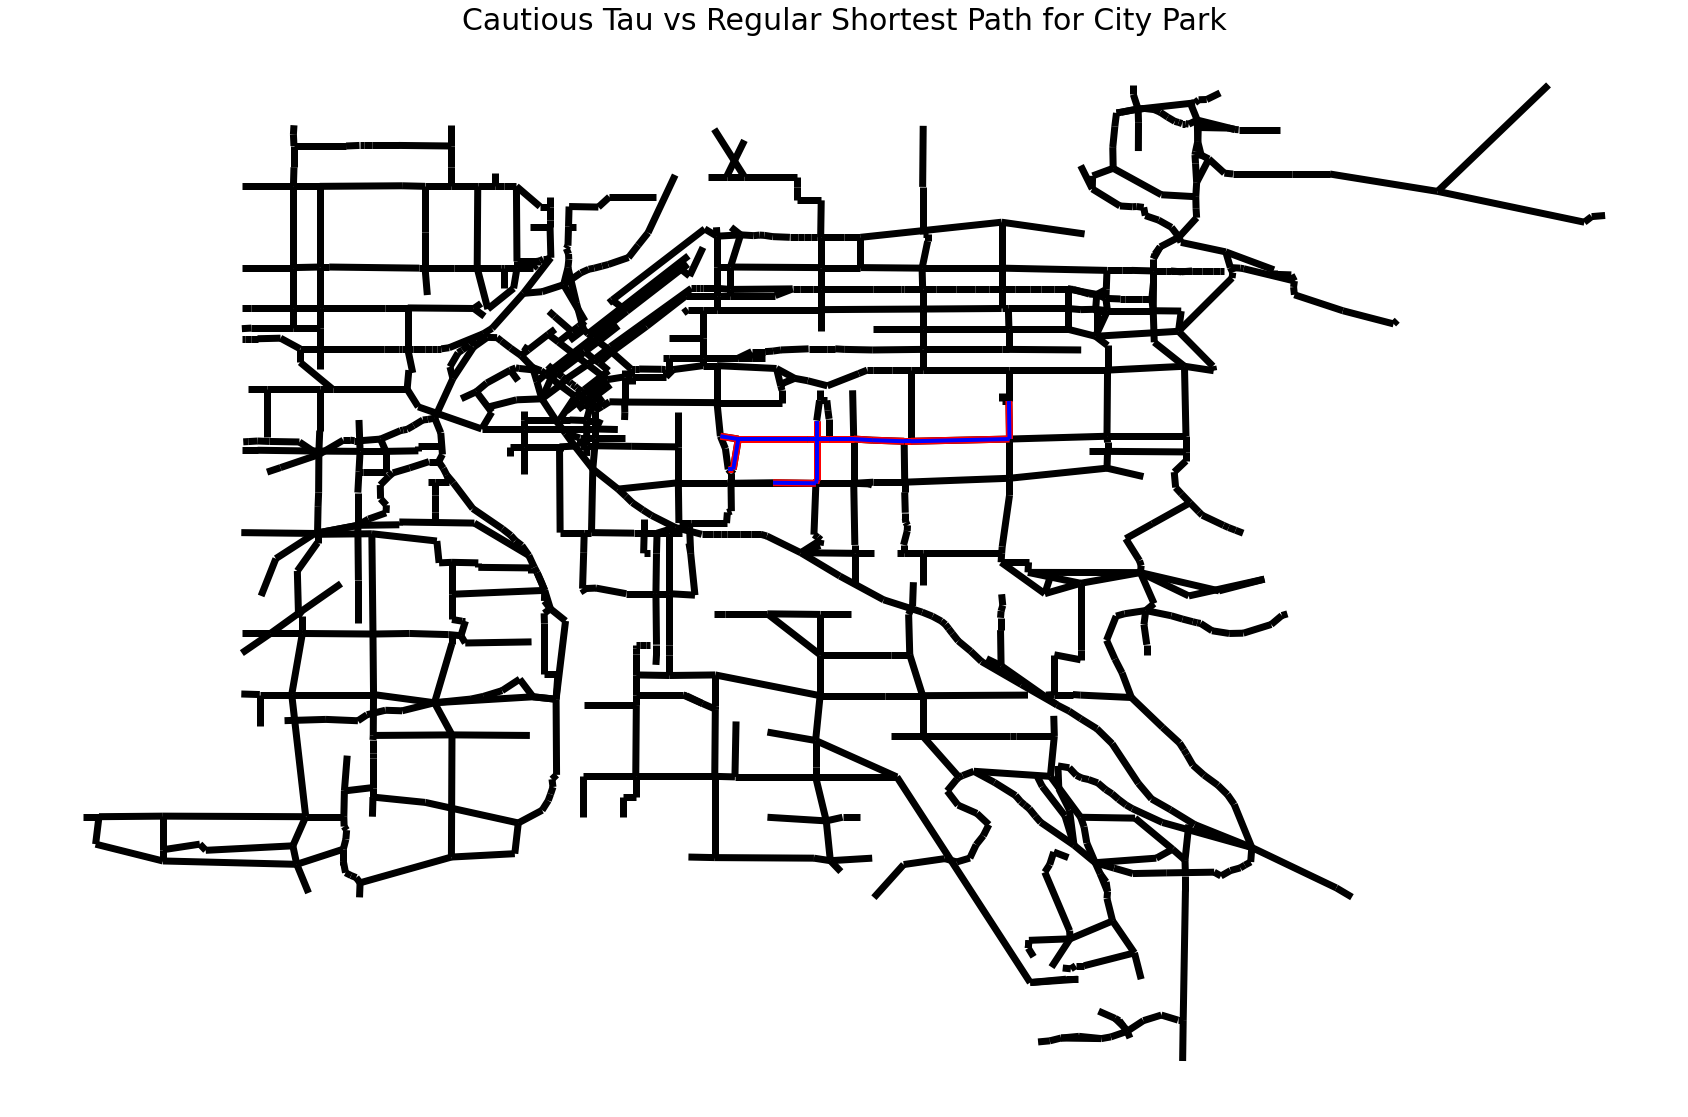

In [38]:
citypark_sp = csv.reader(open('citypark_sp.csv'), delimiter=',')
dest = 834
top_num = 5
url_sp = "https://raw.githubusercontent.com/DillWithIt77/D2P_Spring_2022/main/shortest_path_res/citypark_res.csv"
string2 = "City Park"

# Cautious cyclist
citypark_tau_c = csv.reader(open('tau_results/citypark_tau_cautious_paths.csv'), delimiter=',')
url_tau_c = "https://raw.githubusercontent.com/DillWithIt77/D2P_Spring_2022/main/tau_results/citypark_tau_distances_cautious.csv"
string = "Cautious"

tau_vs_sp(citypark_sp, citypark_tau_c, dest, top_num, url_sp, url_tau_c, string, string2)

# #Adventurous cyclist
# citypark_tau_r = csv.reader(open('tau_results/citypark_tau_risky_paths.csv'), delimiter=',')
# url_tau_r = "https://raw.githubusercontent.com/DillWithIt77/D2P_Spring_2022/main/tau_results/citypark_tau_distances_risky.csv"
# string = "Risky"
# tau_vs_sp(citypark_sp, citypark_tau_r, dest, top_num, url_sp, url_tau_r, string, string2)

### Union Station

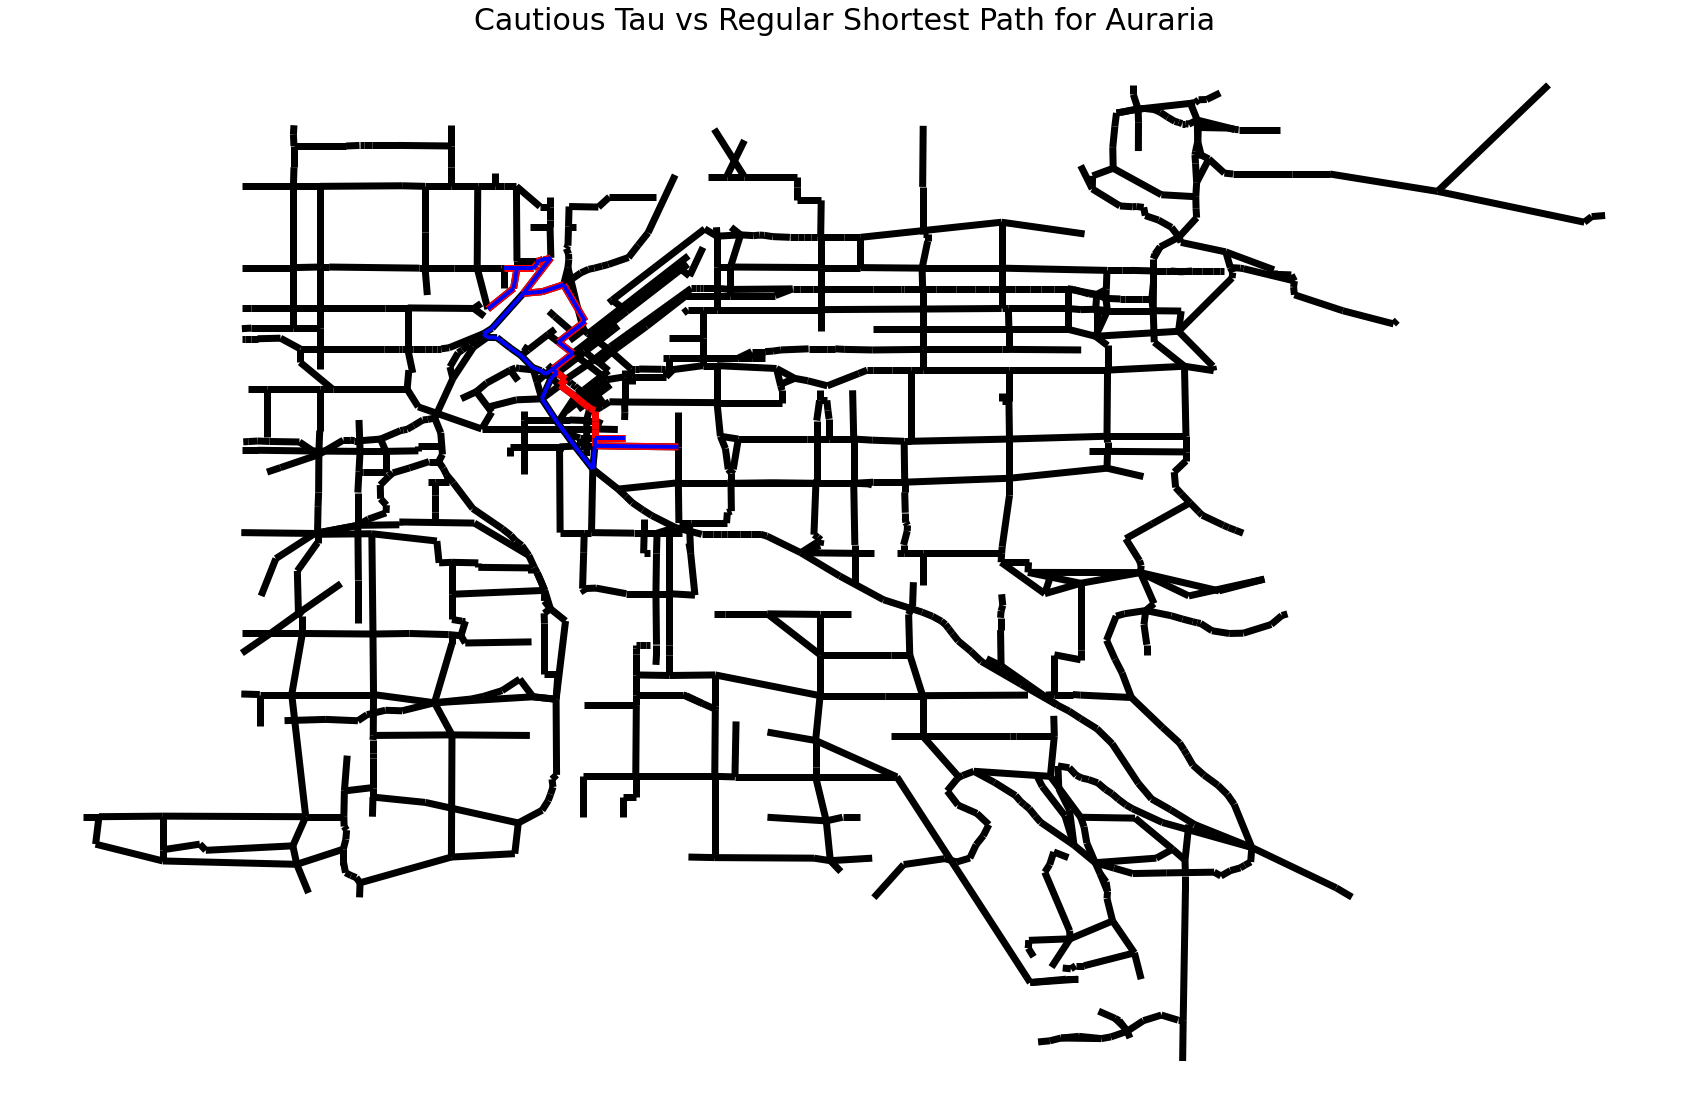

In [40]:
union_sp = csv.reader(open('union_sp.csv'), delimiter=',')
dest = 433
top_num = 5
url_sp = "https://raw.githubusercontent.com/DillWithIt77/D2P_Spring_2022/main/shortest_path_res/union_res.csv"
string2 = "Auraria"

# Cautious cyclist
union_tau_c = csv.reader(open('tau_results/union_tau_cautious_paths.csv'), delimiter=',')
url_tau_c = "https://raw.githubusercontent.com/DillWithIt77/D2P_Spring_2022/main/tau_results/union_tau_distances_cautious.csv"
string = "Cautious"

tau_vs_sp(union_sp, union_tau_c, dest, top_num, url_sp, url_tau_c, string, string2)

# #Adventurous cyclist
# union_tau_r = csv.reader(open('tau_results/union_tau_risky_paths.csv'), delimiter=',')
# url_tau_r = "https://raw.githubusercontent.com/DillWithIt77/D2P_Spring_2022/main/tau_results/union_tau_distances_risky.csv"
# string = "Risky"
# tau_vs_sp(union_sp, union_tau_r, dest, top_num, url_sp, url_tau_r, string, string2)